<a href="https://colab.research.google.com/github/farrakhnizam786/Week-1/blob/main/garbage_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
techsash_waste_classification_data_path = kagglehub.dataset_download('techsash/waste-classification-data')

print('Data source import complete.')


Data source import complete.


<span style="color: white; background-color: green; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">♻️Garbage classification
</span>


![](http://www.clearitwaste.co.uk/wp-content/uploads/2022/01/xCIW_Waste.png.pagespeed.ic.D8betJh5Mf.png)

# 1- Import Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import tensorflow
import kagglehub

import os
import random
from PIL import Image

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [10]:
import zipfile

zip_path = '/content/data.zip'
extract_path = '/content/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ ZIP extracted to /content/data")


✅ ZIP extracted to /content/data


In [11]:
import os

print("📁 Folders inside /content/data:")
print(os.listdir('/content/data'))


📁 Folders inside /content/data:
['archive (2)']


In [12]:
import os

folder_path = '/content/data/archive (2)'
print("📂 Files and folders inside 'archive (2)':")
print(os.listdir(folder_path))


📂 Files and folders inside 'archive (2)':
['DATASET']


In [13]:
import os

dataset_path = '/content/data/archive (2)/DATASET'
print("📂 Files and folders inside 'DATASET':")
print(os.listdir(dataset_path))


📂 Files and folders inside 'DATASET':
['TRAIN', 'DATASET', 'TEST']


# 2 - Viewing Sample Images

✅ Contents of TRAIN folder:
['O', 'R']


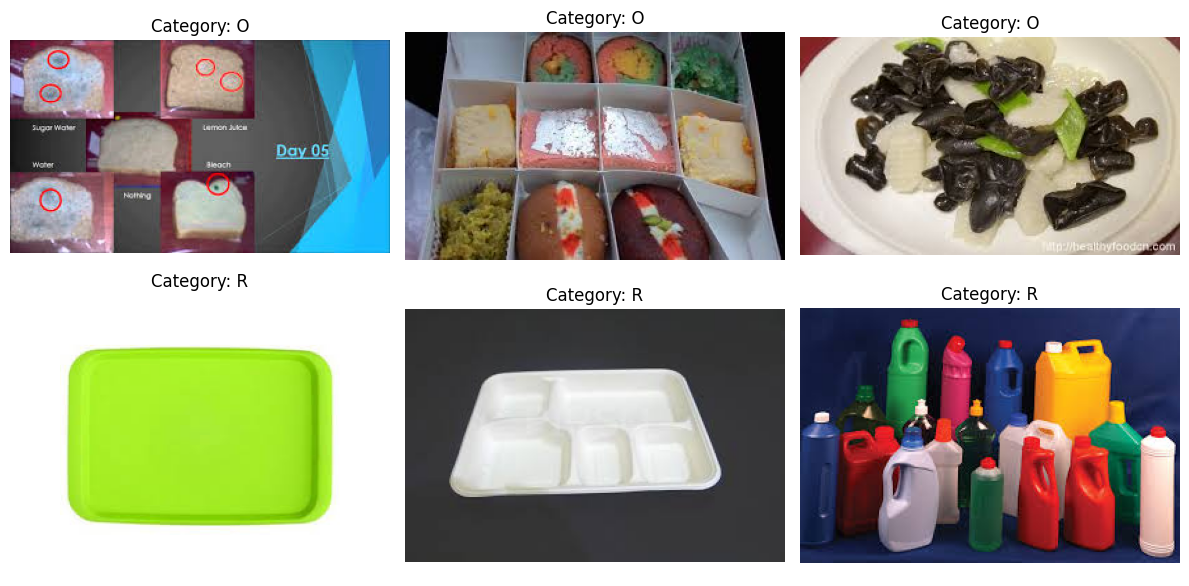

In [14]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Set the correct base path to where 'O' and 'R' folders are
base_path = "/content/data/archive (2)/DATASET/TRAIN"

# Confirm what’s inside the TRAIN folder
print("✅ Contents of TRAIN folder:")
print(os.listdir(base_path))  # Should list ['O', 'R']

# Folder names for the two categories
categories = ['O', 'R']

# Create a 2x3 grid for displaying 3 random images from each category
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for row, category in enumerate(categories):
    category_path = os.path.join(base_path, category)
    image_files = os.listdir(category_path)
    selected_images = random.sample(image_files, 3)

    for col, img_file in enumerate(selected_images):
        img_path = os.path.join(category_path, img_file)
        img = Image.open(img_path)

        ax = axes[row][col]
        ax.imshow(img)
        ax.set_title(f"Category: {category}")
        ax.axis('off')

plt.tight_layout()
plt.show()


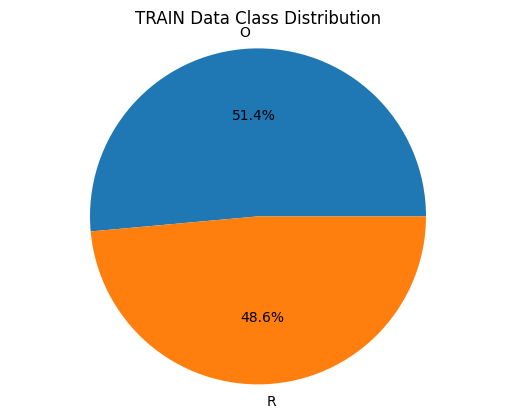

In [15]:
import os
import matplotlib.pyplot as plt

# ✅ Updated path to your TRAIN folder
train_dir = '/content/data/archive (2)/DATASET/TRAIN'

# Class labels (folders 'O' and 'R')
labels = ['O', 'R']

# Count images in each class folder
counts = [len(os.listdir(os.path.join(train_dir, label))) for label in labels]

# Plot the pie chart
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title("TRAIN Data Class Distribution")
plt.axis('equal')
plt.show()


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 3 - Data Augumentation

In [17]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define training and validation data generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    zoom_range=0.4,
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    validation_split=0.2  # 20% data for validation
)

valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2
)

# Path to your TRAIN folder
data_path = '/content/data/archive (2)/DATASET/TRAIN'

# Load training dataset
train_dataset = train_datagen.flow_from_directory(
    directory=data_path,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=128,
    subset='training'  # Only training subset
)

# Load validation dataset
valid_dataset = valid_datagen.flow_from_directory(
    directory=data_path,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=128,
    subset='validation'  # Only validation subset
)


Found 29 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [19]:
from tensorflow.keras.applications import VGG16


# 4- Model Building - VGG16

In [20]:
# Defining Model

base_model = VGG16(input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")

In [21]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [22]:
# Summary

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout  # Since you're using Dropout too

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization, Dense, Activation
from tensorflow.keras.applications import VGG16

# Load pre-trained VGG16 model
base_model = VGG16(input_shape=(224, 224, 3),
                   include_top=False,
                   weights='imagenet')

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Define the model architecture
model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,927,873 (106.54 MB)

 Trainable params: 13,160,961 (50.21 MB)

 Non-trainable params: 14,766,912 (56.33 MB)

In [25]:
# Summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,927,873 (106.54 MB)

 Trainable params: 13,160,961 (50.21 MB)

 Non-trainable params: 14,766,912 (56.33 MB)

In [26]:
import tensorflow as tf  # Add this import at the top of your code

# Model Compile
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=adam)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Defining Callbacks
filepath = './best_model.keras'

earlystopping = EarlyStopping(monitor='val_accuracy',
                            mode='max',
                            patience=2,
                            verbose=1)

checkpoint = ModelCheckpoint(filepath,
                           monitor='val_accuracy',
                           mode='max',
                           save_best_only=True,
                           verbose=1)

callback_list = [earlystopping, checkpoint]

In [28]:
# Defining Callbacks

filepath = './best_model.keras'

earlystopping = EarlyStopping(monitor='val_accuracy',
                              mode='max',
                              patience=2,
                              verbose=1)

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

callback_list = [earlystopping, checkpoint]

In [29]:
# Model Fitting

model_history = model.fit(train_dataset,
                          validation_data=valid_dataset,
                          epochs=5,
                          callbacks=callback_list,
                          verbose=1)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.4828 - loss: 0.8302
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to ./best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - accuracy: 0.4828 - loss: 0.8302 - val_accuracy: 1.0000 - val_loss: 0.2180
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.8966 - loss: 0.2461
Epoch 2: val_accuracy did not improve from 1.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.8966 - loss: 0.2461 - val_accuracy: 1.0000 - val_loss: 0.0992
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.9655 - loss: 0.1838
Epoch 3: val_accuracy did not improve from 1.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.9655 - loss: 0.1838 - val_accuracy: 1.0000 - val_loss: 0.0710
Epoch 3: early stopping


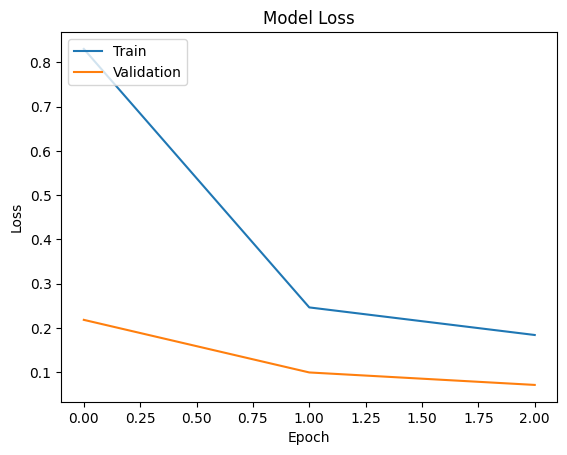

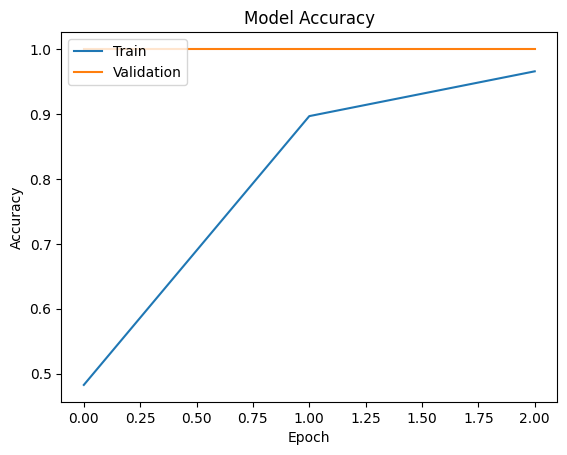

In [30]:
# Summarize the model loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Summarize model accuracy

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Test Data Generator (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load test dataset
test_data = test_datagen.flow_from_directory(
    directory='/content/data/archive (2)/DATASET/TEST',  # Changed to your directory structure
    target_size=(224, 224),
    class_mode='binary',
    batch_size=128,
    shuffle=False  # Typically we don't shuffle test data
)

Found 39 images belonging to 2 classes.


In [32]:
# First make sure you have these imports
from tensorflow.keras.models import load_model
import numpy as np

# Load your saved model (if you saved it during training)
model = load_model('./best_model.keras')  # or whatever path you used

# Evaluate the model on test data
results = model.evaluate(test_data)

# Print the results
print("\nTest Evaluation Results:")
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")

# If you want class predictions instead of just evaluation metrics:
test_data.reset()  # Important if you've used this generator before
predictions = model.predict(test_data)
predicted_classes = np.round(predictions).flatten()  # For binary classification

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.5385 - loss: 0.7568

Test Evaluation Results:
Loss: 0.7568
Accuracy: 0.5385
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step


# 5- Model Building -RESNET50

In [33]:
from tensorflow.keras.applications import ResNet50

In [34]:
resnet = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)


In [35]:
# Freezing Layers

for layer in resnet.layers:
    layer.trainable=False

In [36]:
# Defining Layers

model2=Sequential()
model2.add(resnet)
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(BatchNormalization())
model2.add(Dense(512,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(512,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1,activation='sigmoid'))

In [37]:
# Summary

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100352)         │       401,408 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,637,121 (288.53 MB)

 Trainable params: 51,846,657 (197.78 MB)

 Non-trainable params: 23,790,464 (90.75 MB)

In [38]:
adam = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model2.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=adam)

In [39]:
# Defining Callbacks

earlystopping = EarlyStopping(monitor='val_accuracy',
                              mode='max',
                              patience=2,
                              verbose=1)


callback_list = [earlystopping]

In [40]:
# Model Fitting

history = model2.fit(train_dataset,
                          validation_data=valid_dataset,
                          epochs=5,
                          callbacks=callback_list,
                          verbose=1)

Epoch 1/5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.7931 - loss: 0.5376

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.7931 - loss: 0.5376 - val_accuracy: 0.6667 - val_loss: 0.6855
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.6552 - loss: 0.6868 - val_accuracy: 0.6667 - val_loss: 0.4792
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.7586 - loss: 0.5176 - val_accuracy: 0.8333 - val_loss: 0.3323
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.7586 - loss: 0.4881 - val_accuracy: 0.8333 - val_loss: 0.2984
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.7931 - loss: 0.3505 - val_accuracy: 1.0000 - val_loss: 0.3158


In [41]:
model2.evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.5641 - loss: 0.8451


[0.8451237082481384, 0.5641025900840759]

# 6- Image Prediction Demo

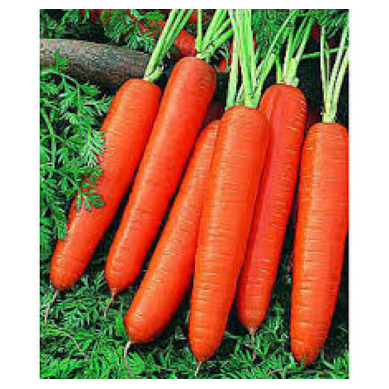

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
The image belongs to **Organic waste** category


In [42]:
# Load and preprocess the image
img = load_img('/kaggle/input/waste-classification-data/DATASET/TEST/O/O_12572.jpg', target_size=(224, 224))
img_array = img_to_array(img) / 255.0  # Normalize to [0,1]
plt.imshow(img_array)
plt.axis('off')
plt.show()


# Expand dimensions to match model input shape: (1, 224, 224, 3)
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)

# Interpret the prediction
if prediction[0][0] > 0.5:
    print("The image belongs to **Recycle waste** category")
else:
    print("The image belongs to **Organic waste** category")

# 7- Saving the Model

In [43]:
model.save('model.h5')

<span style="color: black; background-color: yellow; padding: 10px 20px; border-radius: 10px; font-size: 56px; font-weight: bold;">       ♻️Keep Learning and Keep Upvoting♻️     </span>


In [5]:
from google.colab import files
files.download('garbage_classification.ipynb')  # Optional: Download backup

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>